In [10]:
import numpy as np

import tensorflow as tf
from tensorflow.keras import backend as K
import tensorflow.keras as keras
from keras.legacy import interfaces

import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Conv1D, UpSampling1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.models import Sequential, Model

from ML_Train.Custom_Layers import Dropout_Live
import tflite_runtime.interpreter as tflite

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (15, 4)

from scipy import signal

import os
import pandas as pd
from ML_Train.DBQuerier import DBQuerier as Querier
from sklearn.model_selection import train_test_split
from crawlab_toolbox import plotting as genplt


gpus= tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)



%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [11]:
trainDF = pd.read_csv('Experiment-3-Data/Vib_train_pruned.csv')
testDF = pd.read_csv('Experiment-3-Data/Vib_test_pruned.csv')

X_train = trainDF.loc[:, trainDF.columns != 'dateTime'].values.astype(np.float32)
X_test = testDF.loc[:, testDF.columns != 'dateTime'].values.astype(np.float32)
Y_train = np.loadtxt('Experiment-3-Data/Y_train_pruned.txt',delimiter=',')
Y_test = np.loadtxt('Experiment-3-Data/Y_test_pruned.txt',delimiter=',')

first_good_train = np.argwhere(Y_train[:,0] == 0).flatten()[0]
first_good_test = np.argwhere(Y_test[:,0] == 0).flatten()[0]



X_train_healthy = X_train[first_good_train:,:]
X_valid_healthy = X_test[first_good_test:,:]
X_train_unhealthy = X_train[:first_good_train,:]
X_valid_unhealthy = X_test[:first_good_test,:]

np.random.shuffle(X_train_healthy)
np.random.shuffle(X_valid_healthy)
np.random.shuffle(X_train_unhealthy)
np.random.shuffle(X_valid_unhealthy)

(4200,)


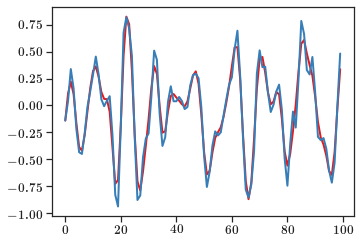

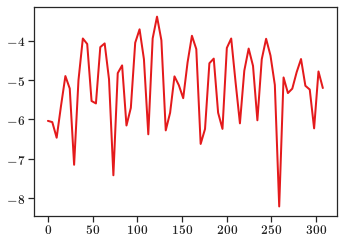

In [33]:
print(X_train_healthy[0,:].shape)
b,a = signal.butter(2, 0.4, btype='low', analog=False, output='ba', fs=None)
test_signal = signal.filtfilt(b, a, X_train_healthy[0,:])
plt.plot(test_signal[:100])
plt.plot(X_train_healthy[0,:100])
plt.show()
freqs,amps = signal.welch(test_signal, fs=20e3, nperseg=4096, scaling='spectrum')

plt.plot(freqs[:64],np.log10(amps)[:64])

In [3]:
divisor=5
expanded_samples = X_train_healthy.shape[0] * divisor
expanded_size = int(X_train_healthy.shape[1] / divisor)

In [11]:
prediction_horizon = 42
num_steps = expanded_size - prediction_horizon
series = X_train_healthy.reshape(expanded_samples,expanded_size,1)
series_valid = X_valid_healthy.reshape(X_valid_healthy.shape[0] * divisor,int(X_valid_healthy.shape[1] / divisor),1)
for i in range(10):
    np.random.shuffle(series)
    np.random.shuffle(series_valid)
X_train = series[:, :num_steps]
X_valid = series_valid[:,:num_steps]
Y = np.empty((expanded_samples, expanded_size - prediction_horizon, prediction_horizon))
for step_ahead in range(1, prediction_horizon + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + expanded_size - prediction_horizon, 0]
Y_train = Y

Y = np.empty((X_valid_healthy.shape[0] * divisor, int(X_valid_healthy.shape[1] / divisor) - prediction_horizon, prediction_horizon))
for step_ahead in range(1, prediction_horizon + 1):
    Y[..., step_ahead - 1] = series_valid[..., step_ahead:step_ahead + int(X_valid_healthy.shape[1] / divisor) - prediction_horizon, 0]
Y_valid = Y



In [12]:
X_train.shape

(750, 798, 1)

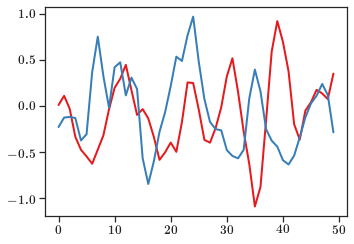

In [13]:
max_index = 50
# plt.plot(Vibration[0,:max_index,0])
plt.plot(X_train[1,:max_index,0])
# plt.plot(X_train[2,:max_index,0])
# plt.plot(X_train[3,:max_index,0])
# plt.plot(X_train[4,:max_index,0])
plt.plot(X_train[26,:max_index,0])

In [14]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -prediction_horizon:], Y_pred[:, -prediction_horizon:])


In [15]:
np.random.seed(42)
tf.random.set_seed(42)
keras.backend.clear_session()

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[798, 1]))
filters = (1, 2, 4, 8, 16)
for rate in filters:
    model.add(keras.layers.Conv1D(filters=32, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
    model.add(keras.layers.BatchNormalization())
# model.add(Dropout(0.3))
for rate in filters:
    model.add(keras.layers.Conv1D(filters=32, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
    model.add(keras.layers.BatchNormalization())
# model.add(Dropout(0.3))
for rate in filters:
    model.add(keras.layers.Conv1D(filters=32, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
    model.add(keras.layers.BatchNormalization())
model.add(Dropout(0.5))
# model.add(Dropout_Live(0.2))
model.add(keras.layers.Conv1D(filters=prediction_horizon, kernel_size=1))
# model.add(Dense(prediction_horizon,activation='relu'))
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
# model.compile(loss="mse", optimizer="adam")

In [16]:
history = model.fit(X_train, Y_train, epochs=20,batch_size=32,
                    validation_data=(X_valid, Y_valid))

Train on 750 samples, validate on 430 samples
Epoch 1/20
750/750 [==============================] - 6s 8ms/sample - loss: 1.7385 - last_time_step_mse: 1.7699 - val_loss: 0.2987 - val_last_time_step_mse: 0.3012
Epoch 2/20
750/750 [==============================] - 1s 827us/sample - loss: 1.1849 - last_time_step_mse: 1.1827 - val_loss: 0.3016 - val_last_time_step_mse: 0.3040
Epoch 3/20
750/750 [==============================] - 1s 823us/sample - loss: 0.8876 - last_time_step_mse: 0.8653 - val_loss: 0.3091 - val_last_time_step_mse: 0.3119
Epoch 4/20
750/750 [==============================] - 1s 817us/sample - loss: 0.7260 - last_time_step_mse: 0.7155 - val_loss: 0.3215 - val_last_time_step_mse: 0.3247
Epoch 5/20
750/750 [==============================] - 1s 840us/sample - loss: 0.6241 - last_time_step_mse: 0.6173 - val_loss: 0.3249 - val_last_time_step_mse: 0.3283
Epoch 6/20
750/750 [==============================] - 1s 819us/sample - loss: 0.5526 - last_time_step_mse: 0.5464 - val_loss: 

In [25]:
X_train.shape

(750, 798, 1)

In [113]:
model_file = '/home/dnewman/TF_Models/model'

model.save(model_file + '.h5',save_format='tf')

def save_tflite(base_name):
        file =base_name +'.h5'
        converter = tf.lite.TFLiteConverter.from_keras_model(model)
        tflite_model = converter.convert()
        open(base_name+".tflite", "wb").write(tflite_model)
        
save_tflite(model_file)

In [114]:
def control_chart_data(X,Y):

    means = np.zeros(X.shape[0])
    variances = np.zeros(X.shape[0])
    
    for i in range(X.shape[0]):
        mean,variance = lite_result(X[i,...].flatten(),Y[i,...])

        means[i] = mean
        variances[i] = variance

    avg_mean = np.mean(means)
    avg_std = np.std(means)

    var_mean = np.mean(variances)
    var_std = np.std(variances)

    return avg_mean,avg_std,var_mean,var_std,means,variances        

def lite_result(X,Y):
    

    interpreter = tflite.Interpreter(model_path="/home/dnewman/TF_Models/model.tflite")
    interpreter.allocate_tensors()


    # Get input and output tensors.
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Test model on random input data.
    input_shape = input_details[0]['shape']
    output_shape = output_details[0]['shape']
    # input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
    input_data = X.reshape(input_shape).astype(np.float32)

    num_samples = 1

    all_outputs = np.zeros((num_samples,output_shape[1],output_shape[2]))

    for i in range(num_samples):

        interpreter.set_tensor(input_details[0]['index'], input_data)
        interpreter.invoke()
        

        # The function `get_tensor()` returns a copy of the tensor data.
        # Use `tensor()` in order to get a pointer to the tensor.
        output_data = interpreter.get_tensor(output_details[0]['index']).reshape(output_shape)

        all_outputs[i,:,:] = output_data


    import pdb
    pdb.set_trace()

    mse = keras.metrics.mean_squared_error(Y[-prediction_horizon:,-1],output_data[:,input_shape[1]:input_shape[1]+prediction_horizon,-1].flatten())
    means = np.mean(mse)

#     mse = 1 / num_samples * np.sum((all_outputs - input_data)**2,axis=1)
#     mse = mse.reshape(int(mse.shape[0] / num_samples),num_samples)

    variances = np.var(mse)

    return means,variances

In [115]:
_,_,_,_,means,variances = control_chart_data(X_valid,Y_valid)

> <ipython-input-114-b65f1088292e>(58)lite_result()
-> mse = keras.metrics.mean_squared_error(Y[-prediction_horizon:,-1],output_data[:,input_shape[1]:input_shape[1]+prediction_horizon,-1].flatten())


(Pdb)  input_data.shape


(1, 798, 1)


(Pdb)  input_data[0,-100:,0]


array([-1.29888 , -1.87165 , -0.900697,  0.813146,  1.85631 ,  1.36841 ,
       -0.248152, -1.66003 , -1.70273 , -0.34103 ,  1.30195 ,  1.87109 ,
        0.896971, -0.816968, -1.85708 , -1.36548 ,  0.252351,  1.66205 ,
        1.7009  ,  0.336862, -1.30502 , -1.87053 , -0.89324 ,  0.820785,
        1.85783 ,  1.36255 , -0.25655 , -1.66405 , -1.69906 , -0.332692,
        1.30808 ,  1.86995 ,  0.889505, -0.824599, -1.85858 , -1.35962 ,
        0.260747,  1.66605 ,  1.69721 ,  0.32852 , -1.31113 , -1.86937 ,
       -0.885766,  0.828408,  1.85932 ,  1.35667 , -0.264943, -1.66804 ,
       -1.69535 , -0.324347,  1.31417 ,  1.86877 ,  0.882022, -0.832213,
       -1.86005 , -1.35373 ,  0.269137,  1.67002 ,  1.69348 ,  0.320172,
       -1.31721 , -1.86817 , -0.878273,  0.836015,  1.86076 ,  1.35077 ,
       -0.273331, -1.67199 , -1.6916  , -0.315995,  1.32024 ,  1.86755 ,
        0.874521, -0.839811, -1.86147 , -1.34781 ,  0.277522,  1.67395 ,
        1.68972 ,  0.311817, -1.32327 , -1.86693 , 

(Pdb)  output_data[0,-42:,0]


array([ 1.7712703 ,  1.2658994 , -0.27406034, -1.5968902 , -1.5546641 ,
       -0.29912534,  1.2634988 ,  1.6853038 ,  0.859501  , -0.7656163 ,
       -1.4996791 , -0.9999428 ,  0.17081977,  1.5601318 ,  1.3904929 ,
        0.38807735, -0.9529045 , -1.3967252 , -0.4419906 ,  0.70904773,
        1.5912024 ,  1.2323778 , -0.07796268, -1.0890306 , -0.64302176,
       -0.28296444,  0.15976569, -0.5235132 ,  0.4249316 ,  0.15374753,
       -0.62005717, -0.30822393,  0.09202095, -0.04450221, -0.14420992,
       -0.21090388, -0.35312152, -0.34540334, -0.20379291, -0.1120796 ,
       -0.23247913, -0.17572616], dtype=float32)


(Pdb)  output_data[0,-50:,0]


array([ 0.24337918,  1.6015722 ,  1.581692  ,  0.24889511, -1.2445722 ,
       -1.7942116 , -0.8606751 ,  0.8191435 ,  1.7712703 ,  1.2658994 ,
       -0.27406034, -1.5968902 , -1.5546641 , -0.29912534,  1.2634988 ,
        1.6853038 ,  0.859501  , -0.7656163 , -1.4996791 , -0.9999428 ,
        0.17081977,  1.5601318 ,  1.3904929 ,  0.38807735, -0.9529045 ,
       -1.3967252 , -0.4419906 ,  0.70904773,  1.5912024 ,  1.2323778 ,
       -0.07796268, -1.0890306 , -0.64302176, -0.28296444,  0.15976569,
       -0.5235132 ,  0.4249316 ,  0.15374753, -0.62005717, -0.30822393,
        0.09202095, -0.04450221, -0.14420992, -0.21090388, -0.35312152,
       -0.34540334, -0.20379291, -0.1120796 , -0.23247913, -0.17572616],
      dtype=float32)


(Pdb)  Y[0,-50:,0]


*** IndexError: too many indices for array


(Pdb)  Y[-50:,0]


array([ 1.86877 ,  0.882022, -0.832213, -1.86005 , -1.35373 ,  0.269137,
        1.67002 ,  1.69348 ,  0.320172, -1.31721 , -1.86817 , -0.878273,
        0.836015,  1.86076 ,  1.35077 , -0.273331, -1.67199 , -1.6916  ,
       -0.315995,  1.32024 ,  1.86755 ,  0.874521, -0.839811, -1.86147 ,
       -1.34781 ,  0.277522,  1.67395 ,  1.68972 ,  0.311817, -1.32327 ,
       -1.86693 , -0.870763,  0.843604,  1.86217 ,  1.34484 , -0.281713,
       -1.67591 , -1.68782 , -0.307637,  1.32629 ,  1.8663  ,  0.867002,
       -0.847392, -1.86286 , -1.34186 ,  0.285902,  1.67785 ,  1.68592 ,
        0.303456, -1.3293  ])


(Pdb)  output_data[0,-100:,0]


array([-0.25317165, -1.5867282 , -1.6355021 , -0.31307423,  1.2405155 ,
        1.7692509 ,  0.8324955 , -0.78907263, -1.7586805 , -1.2973397 ,
        0.21933264,  1.589575  ,  1.5880228 ,  0.27274626, -1.2318192 ,
       -1.7994452 , -0.8602222 ,  0.80785054,  1.7561045 ,  1.2794182 ,
       -0.2622765 , -1.5895655 , -1.6332899 , -0.30514994,  1.2430798 ,
        1.767325  ,  0.8272738 , -0.7968105 , -1.7589985 , -1.2904015 ,
        0.2307439 ,  1.595287  ,  1.5838714 ,  0.26006866, -1.2385544 ,
       -1.7978357 , -0.8537632 ,  0.81477314,  1.7575264 ,  1.2731574 ,
       -0.2713883 , -1.592953  , -1.6317195 , -0.2958203 ,  1.2466979 ,
        1.7659074 ,  0.8208132 , -0.80424476, -1.7592353 , -1.2830393 ,
        0.24337918,  1.6015722 ,  1.581692  ,  0.24889511, -1.2445722 ,
       -1.7942116 , -0.8606751 ,  0.8191435 ,  1.7712703 ,  1.2658994 ,
       -0.27406034, -1.5968902 , -1.5546641 , -0.29912534,  1.2634988 ,
        1.6853038 ,  0.859501  , -0.7656163 , -1.4996791 , -0.99

(Pdb)  Y.shape


(798, 42)


(Pdb)  X_valid.shape


(1000, 798, 1)


(Pdb)  Y_valid.shape


(1000, 798, 42)


(Pdb)  input_data.shape


(1, 798, 1)


(Pdb)  exit


BdbQuit: 

In [106]:
np.amax(means)

11.993701934814453

In [100]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 798, 32)           96        
_________________________________________________________________
batch_normalization (BatchNo (None, 798, 32)           128       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 798, 32)           2080      
_________________________________________________________________
batch_normalization_1 (Batch (None, 798, 32)           128       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 798, 32)           2080      
_________________________________________________________________
batch_normalization_2 (Batch (None, 798, 32)           128       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 798, 32)           2

In [75]:
num_samples = 1

X_predict = np.repeat(X_valid,num_samples,axis=0)
Y_predict = np.repeat(Y_valid,num_samples,axis=0)

In [76]:
X_predict.shape
Y_predict.shape

(1000, 798, 42)

In [70]:
predict = model.predict(X_predict)
predict.shape

(1000, 798, 42)

In [17]:
# predict[:,-prediction_horizon:,:].shape
# Y_predict[:,-prediction_horizon:,:].reshape(X_test.shape[0] * prediction_horizon,prediction_horizon).shape

In [18]:
# print(predict.shape)
# Y_predict_test = Y_predict[:,-prediction_horizon:,:].reshape(X_train.shape[0] * prediction_horizon,prediction_horizon)
# predict_test = predict[:,-prediction_horizon:,:].reshape(X_train.shape[0] * prediction_horizon,prediction_horizon)
# mse = 1 / num_samples * np.sum((Y_predict_test - predict_test)**2,axis=-1)
# mse = mse.reshape(int(mse.shape[0] / prediction_horizon),prediction_horizon)
# print(mse.shape)

In [116]:
mse = keras.metrics.mean_squared_error(predict[:, -prediction_horizon:, -1],Y_predict[:, -prediction_horizon:, -1])
# mse = mse.reshape(int(mse.shape[0] / num_samples),prediction_horizon)
print(mse.shape)

(1000,)


In [117]:
np.amax(mse)

0.011454828979580368

In [20]:
# means = np.mean(mse,axis=1)
# variances = np.var(mse,axis=1)

control_mean = np.mean(mse[:200])
control_std = np.std(mse[:200])

# control_mean_var = np.mean(variances[:200])
# control_std_var = np.std(variances[:200])
# means.shape

In [21]:
control_mean
control_std
control_mean + 3 * control_std

0.010848849029889227

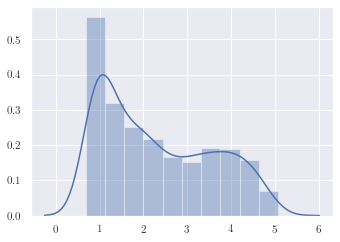

In [88]:
import seaborn as sns
sns.set()
ax = sns.distplot(means)

In [26]:
from scipy.stats import gamma

gamma.fit(mse)

(2.78721102794486, 0.00023690503030121185, 0.0021859618049399395)

In [305]:
X_predict[np.argwhere(mse > control_mean + 3 * control_std).flatten(),:,0].shape

(71, 798)

In [306]:
from scipy import signal
print(X_predict.shape)
freqs,amps = signal.welch(
    X_predict[np.argwhere(mse > control_mean + 3 * control_std).flatten(),:,0],fs=4200,nperseg=256,scaling='spectrum')


(3500, 798, 1)


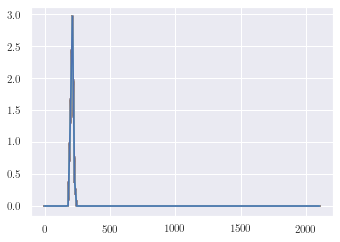

In [307]:
plt.plot(freqs,amps.T)
plt.show()

In [17]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(num_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(num_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, num_steps + 1, -1, 1])


def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(num_steps, num_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    
    plt.plot(np.arange(num_steps, num_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)


In [18]:
model.predict(X_new).shape
Y_new.shape

print(keras.metrics.mean_squared_error(Y_new[0, :, 0],Y_pred[0, :, 0]))


NameError: name 'X_new' is not defined

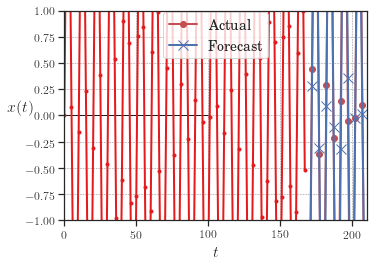

In [98]:
plot_multiple_forecasts(X_, Y_new, model.predict(X_new)[:, -1][..., np.newaxis])
plt.show()

In [57]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 20)          60        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 20)          820       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 20)          820       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 20)          820       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 20)          820       
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 20)          820       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 20)          8

In [100]:
class GatedActivationUnit(keras.layers.Layer):
    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate

In [101]:
def wavenet_residual_block(inputs, n_filters, dilation_rate):
    z = keras.layers.Conv1D(2 * n_filters, kernel_size=2, padding="causal",
                            dilation_rate=dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = keras.layers.Conv1D(n_filters, kernel_size=1)(z)
    return keras.layers.Add()([z, inputs]), z

In [104]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

n_layers_per_block = 6 # 10 in the paper
n_blocks = 1 # 3 in the paper
n_filters = 32 # 128 in the paper
n_outputs = prediction_horizon # 256 in the paper

inputs = keras.layers.Input(shape=[None, 1])
z = keras.layers.Conv1D(n_filters, kernel_size=2, padding="causal")(inputs)
skip_to_last = []
for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
    z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
    skip_to_last.append(skip)
z = keras.activations.relu(keras.layers.Add()(skip_to_last))
z = keras.layers.Conv1D(n_filters, kernel_size=1, activation="relu")(z)
Y_proba = keras.layers.Conv1D(n_outputs, kernel_size=1, activation="softmax")(z)

model = keras.models.Model(inputs=[inputs], outputs=[Y_proba])

In [105]:
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 3500 samples, validate on 1000 samples
Epoch 1/20
3500/3500 [==============================] - 4s 1ms/sample - loss: 3.0878 - last_time_step_mse: 3.0868 - val_loss: 3.0562 - val_last_time_step_mse: 3.0543
Epoch 2/20
3500/3500 [==============================] - 1s 279us/sample - loss: 3.0484 - last_time_step_mse: 3.0461 - val_loss: 3.0438 - val_last_time_step_mse: 3.0417
Epoch 3/20
3500/3500 [==============================] - 1s 289us/sample - loss: 3.0400 - last_time_step_mse: 3.0378 - val_loss: 3.0388 - val_last_time_step_mse: 3.0368
Epoch 4/20
3500/3500 [==============================] - 1s 285us/sample - loss: 3.0373 - last_time_step_mse: 3.0353 - val_loss: 3.0371 - val_last_time_step_mse: 3.0352
Epoch 5/20
3500/3500 [==============================] - 1s 282us/sample - loss: 3.0360 - last_time_step_mse: 3.0341 - val_loss: 3.0360 - val_last_time_step_mse: 3.0343
Epoch 6/20
3500/3500 [==============================] - 1s 285us/sample - loss: 3.0352 - last_time_step_mse: 3.033

In [69]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
# Y_pred = model.predict(X_new)
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

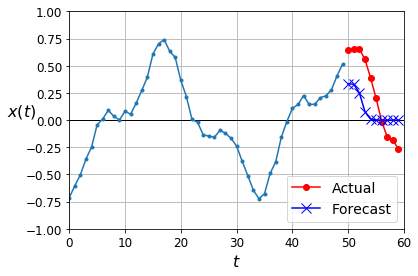

In [70]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [46]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, None, 32)     96          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, None, 64)     4160        conv1d[0][0]                     
__________________________________________________________________________________________________
gated_activation_unit (GatedAct (None, None, 32)     0           conv1d_1[0][0]                   
______________________________________________________________________________________________

In [3]:
import numpy as np
hi = np.arange(1,5)
2**hi

array([ 2,  4,  8, 16])